### Assignment 5 
Implementation of Qlearning and Neural Qlearning

In [9]:
from my_env import EvidenceEnv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Define randomagent. 

In [17]:
class RandomAgent(object):

    def __init__(self, env):
        self.env = env

    def act(self, observation):
        return np.random.choice(self.env.n_action)

    def train(self, a, old_obs, r, new_obs):
        pass
    
class TabularAgent(object):

    def __init__(self, env):
        self.env = env
        self.Q = np.random.rand(4,2)
        self.lr = 0.2
        self.gamma = 0.9
        
    def act(self, observation):
        return np.argmax(self.Q[observation,:])

    def train(self, a, old_obs, r, new_obs):
        self.Q[old_obs, a] = self.Q[old_obs, a] + \
            self.lr*(r + self.gamma*(self.Q[new_obs, self.act(new_obs)]) - self.Q[old_obs, a])
        

Run agent

In [18]:
#number of iterations
n_iter = 1000
#environment specs
env = EvidenceEnv(n=2, p=0.95)
#define agent
agent = RandomAgent(env)
#reset environment and agent
obs = env.reset()
reward = 0
done = False
R = []
for step in range(n_iter):
    env.render
    action = agent.act(obs)
    _obs, r, done, _ = env.step(action)
    #no training involved for random agent
    agent.train(action, obs, reward, _obs)
    obs = _obs
    reward += r
    R.append(reward)

### Assignment 1 
Plot of the cummulative reward.

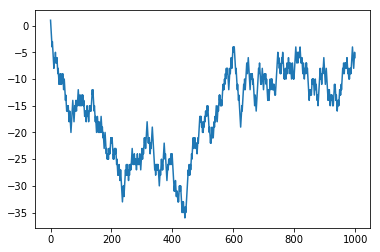

In [19]:
plt.plot(R)
plt.show()

### Assignment 2
Implementation of tabular Q-learning

In [20]:
# number of iterations
n_iter = 1000
#environment specs
tab_env = EvidenceEnv(n=2, p=0.95)
agent = TabularAgent(tab_env)
obs = tab_env.asint(env.reset())
reward = 0
done = False
R = []
for step in range(n_iter):
    env.render
    action = agent.act(obs)
    _obs, r, done, _ = tab_env.step(action)
    _obs = tab_env.asint(_obs)
    agent.train(action, obs, r, _obs)
    obs = _obs
    reward += r
    R.append(reward)

Plot of the cummulative reward over time.

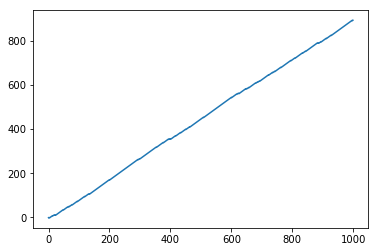

In [21]:
plt.plot(R)
plt.show()

### Assignment 3
Implementation of NeuralQAgent

In [14]:
#todo

Plot of the reward over time.